In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, fft
import itertools
import japanize_matplotlib

In [10]:
# グラフの設定
fontsize_title = 20
fontsize_label = 20
max_xlin = 35

# サンプリング周波数
fs_acc = 390
fs_gyro = 390
fs_pressure = 20

In [11]:
# CSVファイルを読み込む
stairs_press_file = "./logs/stairs_run/Pressure.csv"
stairs_acc_file = "./logs/stairs_run/Accelerometer.csv"
elevator_press_file = "./logs/elevator/Pressure.csv"
elevator_acc_file = "./logs/elevator/Accelerometer.csv"

df_stairs_pressure = pd.read_csv(
    stairs_press_file,
    header=0,
    names=("time", "pressure")
)

df_stairs_acc = pd.read_csv(
    stairs_acc_file,
    header=0,
    names=("time", "x", "y", "z")
)

df_elevator_pressure = pd.read_csv(
    elevator_press_file,
    header=0,
    names=("time", "pressure")
)

df_elevator_acc = pd.read_csv(
    elevator_acc_file,
    header=0,
    names=("time", "x", "y", "z")
)

# 加速度から重力加速度を除去
df_stairs_acc["x"] = df_stairs_acc["x"] - df_stairs_acc["x"].mean()
df_stairs_acc["y"] = df_stairs_acc["y"] - df_stairs_acc["y"].mean()
df_stairs_acc["z"] = df_stairs_acc["z"] - df_stairs_acc["z"].mean()

df_elevator_acc["x"] = df_elevator_acc["x"] - df_elevator_acc["x"].mean()
df_elevator_acc["y"] = df_elevator_acc["y"] - df_elevator_acc["y"].mean()
df_elevator_acc["z"] = df_elevator_acc["z"] - df_elevator_acc["z"].mean()

# 加速度のノルムを計算する
df_stairs_acc['norm'] = np.linalg.norm(df_stairs_acc[['x', 'y', 'z']], axis=1)
df_elevator_acc['norm'] = np.linalg.norm(df_elevator_acc[['x', 'y', 'z']], axis=1)

# 移動平均フィルターをかける
window = 20
df_stairs_pressure['low'] = df_stairs_pressure['pressure'].rolling(window=window).mean()
df_elevator_pressure['low'] = df_elevator_pressure['pressure'].rolling(window=window).mean()


In [12]:
# CSVファイルを読み込む
home_press_file = "./logs/home/Pressure.csv"
home_acc_file = "./logs/home/Accelerometer.csv"

df_home_pressure = pd.read_csv(
    home_press_file,
    header=0,
    names=("time", "pressure")
)

df_home_acc = pd.read_csv(
    home_acc_file,
    header=0,
    names=("time", "x", "y", "z")
)

# 加速度から重力加速度を除去
df_home_acc["x"] = df_home_acc["x"] - df_home_acc["x"].mean()
df_home_acc["y"] = df_home_acc["y"] - df_home_acc["y"].mean()
df_home_acc["z"] = df_home_acc["z"] - df_home_acc["z"].mean()

# 加速度のノルムを計算する
df_home_acc['norm'] = np.linalg.norm(df_home_acc[['x', 'y', 'z']], axis=1)

# 移動平均フィルターをかける
df_home_pressure['low'] = df_home_pressure['pressure'].rolling(window=20).mean()


In [13]:
def plot_acc(df, title):
  fig = plt.figure(figsize=(10, 3))
  
  plt.title(title)
  plt.xlabel('time[s]')
  plt.ylabel('accelerometer\n[m/s^2]')
  plt.plot(df['time'], df['norm'])
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
  plt.xlim(0, 35)
  plt.ylim(0, 30)

  for i in range(int(df['time'].max() + 1)):
    df_part = df.query(f'{i} <= time < {i+1}')
    var = df_part['norm'].var()
    color = "blue" if var >= 0.1 else "yellow"
    plt.axvspan(i, i+1, color=color, alpha=0.2)

  plt.show()



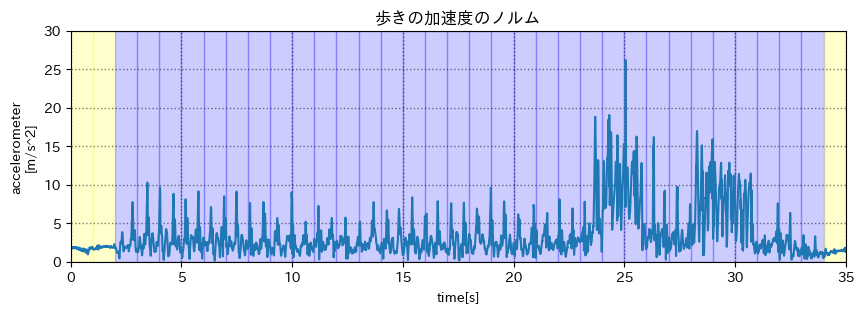

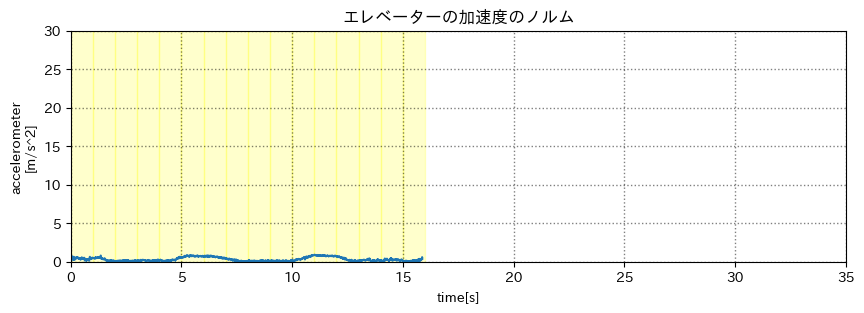

In [14]:
# 加速度
plot_acc(df_stairs_acc, '歩きの加速度のノルム')
plot_acc(df_elevator_acc, 'エレベーターの加速度のノルム')


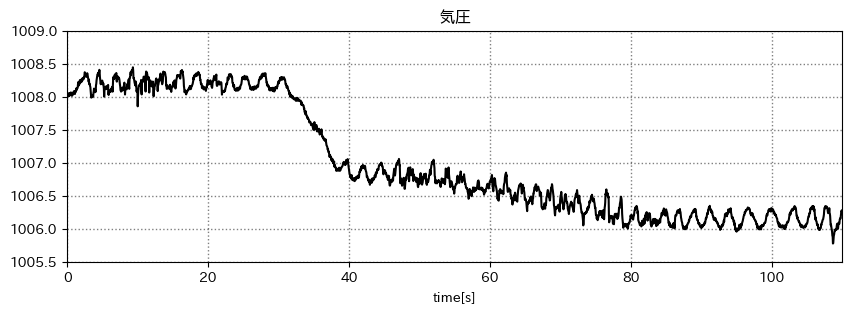

In [15]:
def plot_pressure(df, title, x=(0, 0), y=(0, 0)):
  fig = plt.figure(figsize=(10, 3))
  
  plt.title(title)
  plt.xlabel('time[s]')
  # plt.ylabel('pressure\n[hPa]')
  plt.plot(df['time'], df['pressure'], alpha=1, color='black')
  # plt.plot(df['time'], df['low'], color='black')
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
  if x[0] < x[1]:
    plt.xlim(x[0], x[1])
  if y[0] < y[1]:
    plt.ylim(y[0], y[1])


# 気圧
# plot_pressure(df_stairs_pressure, '歩きの気圧')
# plot_pressure(df_elevator_pressure, 'エレベーターの気圧')
plot_pressure(df_home_pressure, '気圧', (0, 110), (1005.5, 1009))


In [16]:
def correct_graph(data, start_time=0, end_time=0):
  fig = plt.figure(figsize=(10, 3))

  plt.title('正解データ')
  plt.xlabel('time[s]')
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
  plt.ylim(0, 30)
  if start_time < end_time:
    plt.xlim(start_time, end_time)

  for d in data:
    if d['state'] == 'stairs':
      axvspan('stairs', d['s'], d['e'])
    elif d['state'] == 'elevator':
      axvspan('elevator', d['s'], d['e'])
    elif d['state'] == 'walk':
      axvspan('walk', d['s'], d['e'])
    elif d['state'] == 'wait':
      axvspan('wait', d['s'], d['e'])


def elevator_or_stairs(df_acc, df_pressure, start_time=0, end_time=0):
  fig = plt.figure(figsize=(10, 3))

  plt.title('行動の判別')
  plt.xlabel('time[s]')
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
  plt.ylim(0, 30)
  if start_time < end_time:
    plt.xlim(start_time, end_time)

  for i in range(int(df_acc['time'].max() + 1)):
    part_acc = df_acc.query(f'{i} <= time < {i+1}')
    df_part_a = df_pressure.query(f'{i} <= time < {i+1}')
    df_part_b = df_pressure.query(f'{i+1} <= time < {i+2}')

    mean_a = df_part_a['low'].mean()
    mean_b = df_part_b['low'].mean()

    var = part_acc['norm'].var()
    is_move = True if var >= 0.1 else False
    is_updown = True if abs(mean_a - mean_b) >= 0.05 else False

    if is_updown and is_move:
      axvspan('stairs', i, i+1)
    elif is_updown and not is_move:
      axvspan('elevator', i, i+1)
    elif is_move:
      axvspan('walk', i, i+1)
    else:
      axvspan('wait', i, i+1)


def axvspan(state, s, e):
  if state == 'stairs':
    plt.axvspan(s, e, color="red", alpha=0.5)
  elif state == 'walk':
    plt.axvspan(s, e, color="blue", alpha=0.5)
  elif state == 'elevator':
    plt.axvspan(s, e, color="yellow", alpha=1)
  elif state == 'wait':
    plt.axvspan(s, e, color="lightgreen", alpha=0.5)


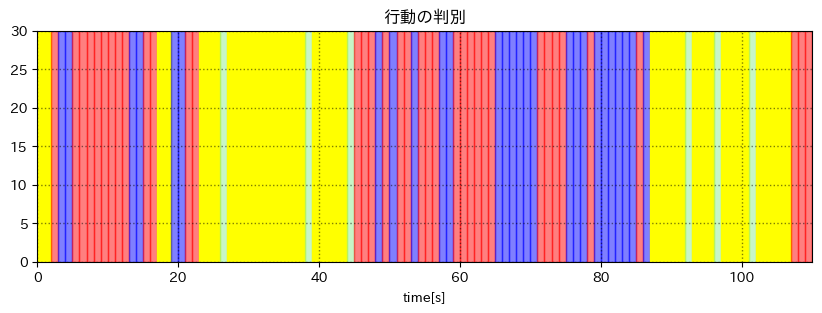

In [17]:
elevator_or_stairs(df_home_acc, df_home_pressure, 0, 110)